# Exercise 11
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-07-05: v.1.0. First public release. 

## Task 1: Laplace Approximation

Laplace's method states that
    \begin{equation}
        \int e^{M f(x)} \approx \sqrt{\frac{2 \pi}{M\left|f^{\prime \prime}\left(x_{0}\right)\right|}} e^{M f\left(x_{0}\right)} \text { as } M \rightarrow \infty,
    \end{equation}
    with $x_0$ as the global maximum of $f$. Using the Laplace's method, we can approximate the integral
    \begin{equation}
        N ! =\int_{0}^{\infty} e^{-t} t^{N} d t.
    \end{equation}
    First, we notice that the integral can be rewritten as
    \begin{align}
        N ! &=\int_{0}^{\infty} e^{-t} t^{N} d t\\
        &= \int_{0}^{\infty} e^{-t} e^{\log(t^{N})} d t\\
        &= \int_{0}^{\infty} e^{N\log(t)-t} d t.
    \end{align}
    Doing a variable substitution $t = Nx$, $dt = N dx$, we get
    \begin{align}
        N ! &= \int_{0}^{\infty} e^{N\log(N)+ N\log(x)-Nx} N d x\\
        &= N^{N+1}\int_{0}^{\infty} e^{N\log(x)-Nx} d x\\
        &= N^{N+1}\int_{0}^{\infty} e^{Nf(x)} d x, 
    \end{align}
    where we defined
    \begin{equation}
        f(x) = \log(x)-x.
    \end{equation}
    We can notice that $f$ is only defined for $x>0$ and has a single extrema at $x_0 = 1$, which is the global maximum. Doing a Taylor expansion of $f$ at this extreme point gives
    \begin{align}
        f(x) &= f(x_0) + f'(x_0)(x-x_0) - \frac{1}{2} f''(x_0)(x-x_0)^2 + \mathcal{O}((x-x_0)^3) \\
        &\approx f(x_0) - \frac{1}{2} |f''(x_0)|(x-x_0)^2,
    \end{align}
    where the first derivative disappeared since $x_0$ is an extrema. Plugging back into the integral yields
    \begin{align}
        N ! &\approx N^{N+1}\int_{0}^{\infty} e^{Nf(x_0) - \frac{1}{2} N|f''(x_0)|(x-x_0)^2} d x\\
        &= N^{N+1} e^{Nf(x_0)}\int_{0}^{\infty} e^{- \frac{1}{2} N|f''(x_0)|(x-x_0)^2} d x\\
        &\approx N^{N+1} e^{Nf(x_0)}\int_{-\infty}^{\infty} e^{-\frac{1}{2} N|f''(x_0)|(x-x_0)^2} d x
    \end{align}
    where the last line is only approximately true since $f$ is technically only defined for $x>0$ in the original functional expression. Nonetheless, since $N$ is large, the squared exponential will have a very narrow width (i.e. small variance), and since the squared exponential will be centered on $x_0 = 1 > 0$, the integral will thus have a negligible contribution from the region $x \leq 0$. However, the benefit of this extension of the integration bounds is that it allows us to manipulate the integral and complete it into a Gaussian integral with mean $\mu = x_0$ and variance $\sigma^2 = 1/\left(N|f''(t_0)|\right)$ as per
    \begin{align}
        N ! &\approx N^{N+1} \sqrt{\frac{2\pi}{N|f''(x_0)|}} e^{Nf(x_0)} \int_{-\infty}^{\infty} \sqrt{\frac{N|f''(x_0)|}{2\pi}} e^{-\frac{1}{2}N|f''(x_0)|(x-x_0)^2} d x\\
        &= N^{N+1} \sqrt{\frac{2\pi}{N|f''(x_0)|}} e^{Nf(x_0)}
    \end{align}
    where we used the fact that the Gaussian is normalized. Finally, plugging in the function value and the second derivative of $f(x)$ at $x_0 = 1$, we arrive at
    \begin{align}
        N ! &\approx N^{N+1} \sqrt{\frac{2\pi}{N|f''(x_0)|}} e^{Nf(x_0)}\\
        &= N^{N+1} \sqrt{\frac{2\pi}{N}} e^{-N}\\
        &= \sqrt{2\pi N} N^N e^{-N}\\
        &= \sqrt{2\pi N} \left(\frac{N}{e}\right)^N,
    \end{align}
    which is valid as $N \rightarrow \infty$, also known as Sterling's approximation.

## Task 2: Extended Kalman Filter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')
import pickle

# Notebook graphics settings: 
%config InlineBackend.figure_format = 'svg' # inline graphics (options: 'svg', 'png', 'retina', etc.)
plt.rcParams['figure.dpi'] = 200            # custom dpi setting for inline png:s

In [2]:
with open('par.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

{'A': array([[ 0.78696704,  0.        ,  0.        ],
       [ 0.        , -0.96591269,  0.        ],
       [ 0.        ,  0.        , -0.64832612]]), 'B': array([[-1.91907565, -0.7336933 ,  1.05133234],
       [-1.49441774,  1.51695287,  1.19369578],
       [-0.59172598, -1.16053358, -0.4258629 ],
       [-1.14043835, -1.15427297, -0.03865492],
       [-0.62295658, -0.15208714,  0.82018262],
       [-1.25632818, -0.40600019, -0.00828886],
       [-0.72288068,  0.26861535,  0.57186431],
       [-0.6753387 , -2.41868384,  1.180724  ],
       [ 2.58204479, -1.18938529, -0.45156152],
       [-0.46179032, -1.39052682,  0.52169952]]), 'Gamma': array([[0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ]

In [3]:
print(data.keys())

dict_keys(['A', 'B', 'Gamma', 'Sigma', 'W', 'mu0', 'h'])


In [4]:
# Extract the matrices and vectors
A     = data['A']
B     = data['B']
gamma = data['Gamma']
sigma = data['Sigma']
W     = data['W']
mu0   = data['mu0']
h     = data['h']

### 2.1: Generate latent and observation time series

In [5]:
def ReLU(x):
    return np.maximum(np.zeros_like(x), x)

In [6]:
def generate_latent_TS(A, W, h, mu0, sigma, T):
    """ 
    Generate a time series of length T, describing the latent model
        z_t = A * z_{t-1} + W * ReLU(z_{t-1}) + h + eps_t, 
    where eps_t ~ N(0, sigma) and ReLU is the rectified linear unit.
    """
    M = A.shape[0] # Dimension of latent space
    assert A.shape == (M, M) and W.shape == (M, M) and h.shape == (M, 1) and mu0.shape == (M, 1) and sigma.shape == (M, M)
    
    z = np.zeros((T, M, 1))
    z[0] = mu0
    eps = np.expand_dims(np.random.multivariate_normal(np.zeros(M), sigma, size=T), axis=-1)
    for t in range(1, T):
        z[t] = A @ z[t-1] + W @ ReLU(z[t-1]) + h + eps[t]
    return z

In [7]:
def generate_obs_TS(B, z, gamma):
    """ 
    Generate a time series of length T from the latent space vector z, describing the observation model
        x_t = B * z_t + nu_t, 
    where nu_t ~ N(0, gamma).
    """
    N, M = B.shape # N = dim(observation space), M = dim(latent space)
    T = z.shape[0] # Length of time series
    assert z.shape[1:] == (M, 1) and gamma.shape == (N, N)
    
    nu = np.expand_dims(np.random.multivariate_normal(np.zeros(N), gamma, size=T), axis=-1)
    x = B @ z + nu
    return x

In [8]:
# From the given model, generate a new time series of specified length. 
M = A.shape[0] # Dimension of latent space
N = B.shape[0] # Dimension of observation space
T = 500        # No. of timesteps to generate 

z = generate_latent_TS(A, W, h, mu0, sigma, T)
x = generate_obs_TS(B, z, gamma)

In [9]:
def plot_TS(x, name='lat', title='Latent space'):    
    for i in range(x.shape[1]):
        plt.plot(x[:, i].squeeze(), label=name+f' var {i+1}')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(title)
    plt.show()

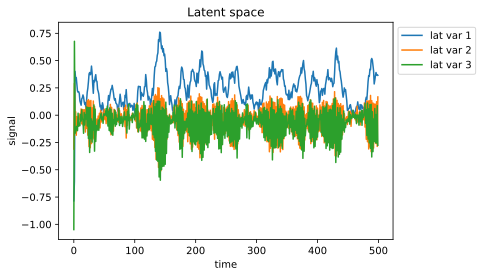

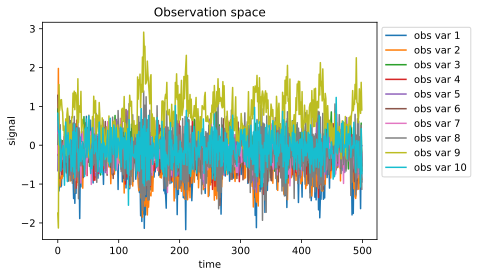

In [10]:
plot_TS(z, name='lat', title='Latent space')
plot_TS(x, name='obs', title='Observation space')

### 2.2: Kalman filter

In [11]:
def kalman_filter(x, mu0, L0, A, B, sigma, gamma, C=None, u=None):
    """
    Kalman filter recursions.
    
    :param x: observed time series, shape=(T, q, 1) where T is the no. of timesteps, q is 
              the dimension of observed space. 
    :param mu0: initial predicted latent state estimate, shape=(p, 1) where p is the dimension of latent space.
    :param L0: initial predicted latent error covariance matrix, shape=(p, p).
    :param A: transition matrix, shape=(p, p).
    :param B: observation matrix, shape=(q, p).
    :param sigma: covariance matrix of the gaussian noise for the process (latent) model, shape=(p, p).
    :param gamma: covariance matrix of the gaussian noise for the observation model, shape=(q, q).
    :param C: (optional) control variable matrix, shape=(p, r).
    :param u: (optional) control variable time series, shape=(T, r, 1)
    """
    T, q, _ = x.shape # Length of time series, dim of observation space
    p = mu0.shape[0]  # Dim of latent space
    
    # Optional control variables
    if C is None and u is None:
        C = np.zeros((p, 1))
        u = np.zeros((T, 1, 1))
    
    # Preallocations
    mu_p = np.zeros((T, p, 1)) # Predicted state estimate (predicted expected value)  
    mu   = np.zeros((T, p, 1)) # Updated state estimate (corrected expected value)
    L    = np.zeros((T, p, p)) # Predicted error covariance (Measurement covariance matrix)
    V    = np.zeros((T, p, p)) # Updated error covariance (Filter covariance matrix) 
   
    # Initial predicted latent space expected value and error covariance matrix.
    mu_p[0] = mu0
    L[0]    = L0
    
    # Do an single correction cycle on the initial values. 
    x_res = x[0] - B @ mu_p[0]
    K_t   = L[0] @ B.T @ np.linalg.inv(B @ L[0] @ B.T + gamma) 
    mu[0] = mu_p[0] + K_t @ x_res
    V[0]  = (np.eye(p) - K_t @ B) @ L[0]
    
    # Kalman filter recursions:
    for t in range(1, T):
        # Prediction/propagation:
        mu_p[t] = A @ mu[t-1] + C @ u[t]   # Predicted state estimate
        L[t]    = A @ V[t-1] @ A.T + sigma # Predicted error covariance
        
        # Update/correction:
        x_res = x[t] - B @ mu_p[t]                                 # Measurement residual
        K_t   = L[t] @ B.T @ np.linalg.inv(B @ L[t] @ B.T + gamma) # Kalman gain, shape=(p, q)
        mu[t] = mu_p[t] + K_t @ x_res                              # Updated state estimate
        V[t]  = (np.eye(p) - K_t @ B) @ L[t]                       # Updated error covariance
    
    return mu, V

In [12]:
def plot_comparison(z, mu, lab='kalman filter'):
    """ 
    :param z: ground truth latent time series
    :param mu: estimated latent time series
    :param lab: legend name for the estimated time series
    """
    # Compare ground truth and the filtered time series
    M = z.shape[1]
    fig, ax = plt.subplots(M, 1, figsize=(10, 8), sharex=True)
    ax = ax.flatten()
    for i in range(M):
        ax[i].plot(z[:, i].squeeze(), alpha=0.75, label='ground truth')
        ax[i].plot(mu[:, i].squeeze(), alpha=0.75, label=lab)
        ax[i].set_ylabel('signal')
        ax[i].set_title(f'Latent variable {i+1}')
    plt.xlabel('time')
    ax[0].legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()
    
    # Calculate mean squared error between estimate and ground truth
    mse = np.mean((z-mu)**2)
    print(f"MSE between {lab} estimate and ground truth: {mse:.6}")

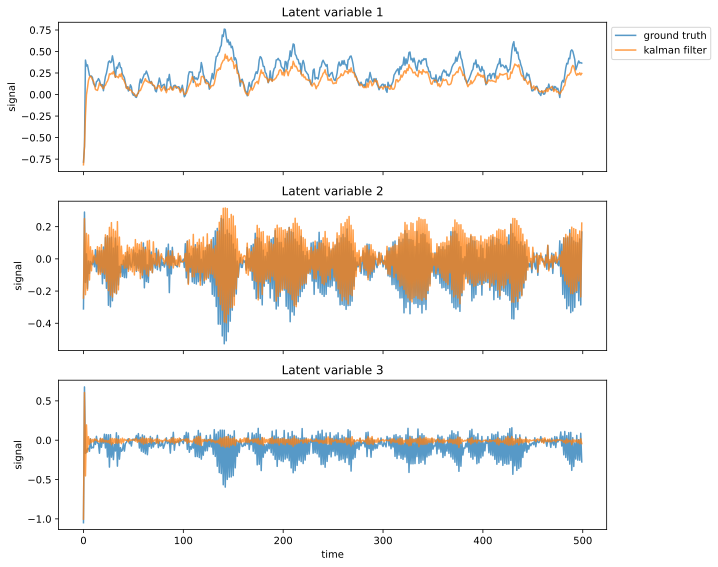

MSE between kalman filter estimate and ground truth: 0.0121687


In [13]:
L0 = 0.01 * np.eye(M) # Invent own initial conditions, since none was supplied in the exercise. 
mu, V = kalman_filter(x, mu0, L0, A, B, sigma, gamma)
plot_comparison(z, mu)

### 2.3 Extended Kalman filter

In [14]:
def lat_model(z):
    return A @ z + W @ ReLU(z) + h
def lat_model_diff(z):
    return A + W * np.heaviside(z, 0)
def obs_model(z):
    return B @ z
def obs_model_diff(z):
    return B

In [15]:
def extended_kalman_filter(x, mu0, L0, sigma, gamma):
    """
    Extended Kalman filter recursions.
    
    :param x: observed time series, shape=(T, q, 1) where T is the no. of timesteps, q is 
              the dimension of observed space. 
    :param mu0: initial predicted latent state estimate, shape=(p, 1) where p is the dimension of latent space.
    :param L0: initial predicted latent error covariance matrix, shape=(p, p).
    :param sigma: covariance matrix of the gaussian noise for the process (latent) model, shape=(p, p).
    :param gamma: covariance matrix of the gaussian noise for the observation model, shape=(q, q).
    """
    T, q, _ = x.shape # Length of time series, dim of observation space
    p = mu0.shape[0]  # Dim of latent space
    
    # Preallocations
    mu_p = np.zeros((T, p, 1)) # Predicted state estimate (predicted expected value)  
    mu   = np.zeros((T, p, 1)) # Updated state estimate (corrected expected value)
    L    = np.zeros((T, p, p)) # Predicted error covariance (Measurement covariance matrix)
    V    = np.zeros((T, p, p)) # Updated error covariance (Filter covariance matrix) 
   
    # Initial predicted latent space expected value and error covariance matrix.
    mu_p[0] = mu0
    L[0]    = L0
    
    # Do an single correction cycle on the initial values.
    H = obs_model_diff(mu_p[0]) # Jacobian of obs. model at initial predicted state estimate.
    x_res = x[0] - obs_model(mu_p[0])
    K_t   = L[0] @ H.T @ np.linalg.inv(H @ L[0] @ H.T + gamma) 
    mu[0] = mu_p[0] + K_t @ x_res
    V[0]  = (np.eye(p) - K_t @ H) @ L[0]
    
    # Kalman filter recursions:
    for t in range(1, T):
        
        F = lat_model_diff(mu[t-1]) # Jacobian of lat. model at previous updated state estimate.
        
        # Prediction/propagation:
        mu_p[t] = lat_model(mu[t-1])       # Predicted state estimate F @ mu[t-1] + C @ u[t] 
        L[t]    = F @ V[t-1] @ F.T + sigma # Predicted error covariance
        
        H = obs_model_diff(mu_p[t]) # Jacobian of obs. model at predicted state estimate.
        
        # Update/correction:
        x_res = x[t] - obs_model(mu_p[t])                          # Measurement residual
        K_t   = L[t] @ H.T @ np.linalg.inv(H @ L[t] @ H.T + gamma) # Kalman gain, shape=(p, q)
        mu[t] = mu_p[t] + K_t @ x_res                              # Updated state estimate
        V[t]  = (np.eye(p) - K_t @ H) @ L[t]                       # Updated error covariance
    
    return mu, V

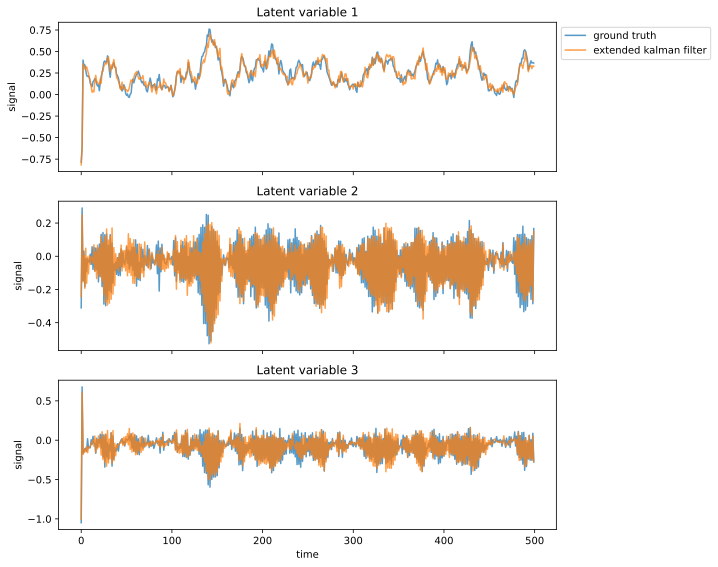

MSE between extended kalman filter estimate and ground truth: 0.00248458


In [16]:
L0 = 0.01 * np.eye(M) # Invent own initial conditions, since none was supplied in the exercise. 
mu, V = extended_kalman_filter(x, mu0, L0, sigma, gamma)
plot_comparison(z, mu, lab='extended kalman filter')

As one can see above, the MSE of the regular Kalman filter and the Extended Kalman filter estimates compared to the ground truth is an order of magnitude smaller for the Extended Kalman filter.